# FITS-cubes Tutorial

## Authors:
Dhanesh Krishnarao (DK), Shravan Shetty, Audra Hernandez, Diego Gonzalez-Casanova

## Learning Goals:

* Read and plot slices across different dimensions of a data cube
* Compare different data sets (2D and 3D) by overploting contours
* Transform coordinate projections and match data resolutions with reproject
* Create intensity moment maps with spectral_cube

## Keywords

FITS-files, FITS-images, FITS-cubes, moment_maps, contours

In the tutorial we will visualize 2D and 3D data sets in different coordinates (galactic and equatorial). 

This tutorial will walk you though a simple visual analysis of the Magellanic Clouds (LMC, SMC, Bridge) using HI 21cm emission and a Herschel 250 micron map. We will learn how to read in data from vizier, query and download matching data from Herschel using astroquery, and plot the resulting images in a multitude of ways. 

The primary libraries we will be using are: [astroquery](http://www.astropy.org/astroquery/), [spectral_cube](https://spectral-cube.readthedocs.io/en/latest/), [aplpy](https://aplpy.github.io/), [reproject](https://reproject.readthedocs.io/en/stable/#), and [matplotlib](https://matplotlib.org/)

# Download the HI Data

We will be using HI 21 cm emission data from the HI4Pi survey (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1610.06175).  We want to look at neutral gas emission from the Magellanic Clouds, learn about the kinematics of the system and column densities. Using the vizier catalog, we have found a relevant data cube to use covering this region of the sky. You can also download an allsky data cube, but this is a very large file, so picking out sub-sections can be useful!

For us, the relevant file is available at this url: (http://cdsarc.u-strasbg.fr/vizier/ftp/cats/J/A+A/594/A116/CUBES/GAL/TAN/TAN_C14.fits)
This will be a FITS data cube in Galactic Coordinates using the Tangential Sky projection.

Sure, we can just download this file directly, but why do that when we can load it up via one line of code, and have it ready to use in our cache!

## Run the following section of code to download this FITS cube

In [12]:
from astropy.utils.data import download_file

hi_datafile = download_file('http://cdsarc.u-strasbg.fr/vizier/ftp/cats/J/A+A/594/A116/CUBES/GAL/TAN/TAN_C14.fits',
                       cache=True, show_progress = True) #Downloads the HI data in a fits file format

Awesome, so now we have a copy of the data file (a FITS file).  So how do we do anything with it?

Lucky for us, the [spectral_cube](https://spectral-cube.readthedocs.io/en/latest/) package does a lot of the nitty gritty work for us to manipulate this data, and even quickly look through it. 
So let's open up our data file and read in the data as a SpectralCube!

The variable 'cube' has the data using SpectralCube and 'hi_data' is the data cube form the fits file without the special formating form SpectralCube

In [13]:
from astropy.io import fits # We use fits to open the actual data file
from spectral_cube import SpectralCube

hi_data = fits.open(hi_datafile) # Open the FITS file for reading
cube = SpectralCube.read(hi_data) # Initiate a SpectralCube
hi_data.close() # Close the FITS file - we already read it in and don't need it anymore!

/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


<div class="alert alert-info">
If you happen to already have the FITS file on your system, you can also skip the fits.open step and just directly read a FITS file with SpectralCube like this:


`
cube = SpectralCube.read(path_to_data_file/TAN_C14.fits') 
`
</div>

So what does this SpectralCube object actually look like? Let's find out!  The first check is to just print out the cube.

In [14]:
print(cube)

SpectralCube with shape=(933, 277, 269) and unit=K:
 n_x:    269  type_x: GLON-TAN  unit_x: deg    range:   286.707162 deg:  320.913024 deg
 n_y:    277  type_y: GLAT-TAN  unit_y: deg    range:   -51.659734 deg:  -28.394756 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s


### Some things to pay attention to here:

As we know, a data cube has three axes. In this case, there is Galactic Longitude (x), Galactic Latitude (y), and a spectral axis in terms a LSR Velocity (z - listed as s with spectral_cube).

The data hidden in the cube lives as an ndarray with shape (n_s, n_y, n_x) so that axis 0 corresponds with the Spectral Axis, axis 1 corresponds with the Galactic Latitude Axis, an daxis 2 corresponds with the Galactic Longitude Axis. 

When we `print(cube)`, we can see the shape, size, and units of all axes as well as the data stored in the cube. With this cube, the units of the data in the cube are temperatures (K). The spatial axes are in degrees, and the Spectral Axis is in (meters / second)

cube also contains information about the coordinates corresponding to the data in the form of a WCS (World Coordinate System) object. 

SpectralCube is clever and keeps all the data masked until you really need it so that you can work with large sets of data. So let's see what our data actually looks like!

SpectralCube has a `quicklook()` method which can give a handy sneak peak preview of the data.  It is useful when you just need to glance at a slice or spectrum without knowing any other information (say, to make sure the data isn't corrupted or is looking at the right region.  

To do this, we simply have to index our cube along one axis (for a slice) or two axes (for a spectrum):

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

INFO: Auto-setting vmin to -4.660e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.058e+01 [aplpy.core]


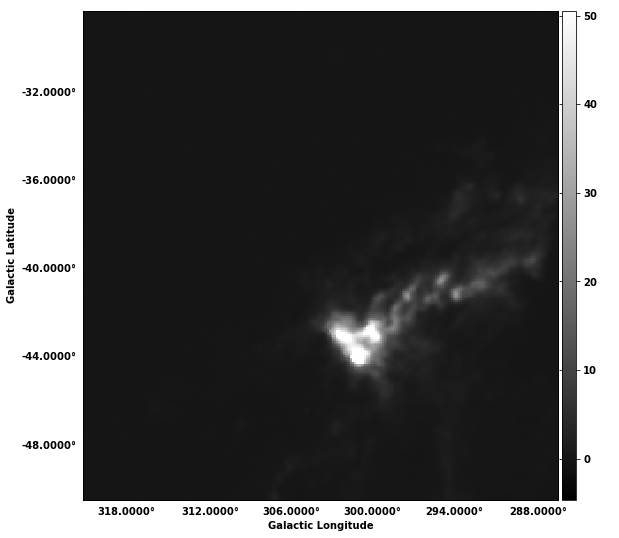

In [27]:
cube[600,:,:].quicklook() # Slice the cube along the spectral axis, and display a quick image

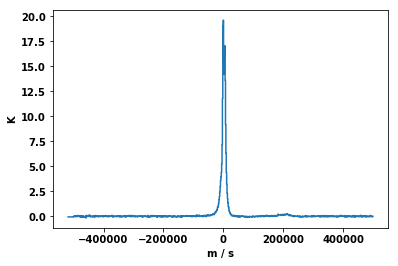

In [25]:
cube[:,150,150].quicklook() # Extract a single spectrum through the data cube

#### Try messing around with slicing the cube along different axes, or picking out different spectra

# Make a smaller cube, focusing on the Magellanic Clouds

The HI data cube we downloaded is bigger than we actually need it to be.  Let's try zooming in on just the part we need and make a new sub_cube. 

The easiest way to do this is just cut out part of cube with indices, but how do we know which index correpsponds with which coordinate value?

Well, we can extract the world coordinates from the cube using the .world() method. 
<div class="alert alert-warning">
Warning: using .world() will extract coordinates from every position you ask for. This can a TON of data if you don't slice through the cube.  One work around, is to slice along two axies, and extract coordinates just along a single dimension.
</div> 

The output of .world is an astropy Quanity which includes units. Extract these astropy Quantity objects by slicing the data.

In [28]:
_, b, _ = cube.world[0,:,0] #extract latitude world coordinates from cube
_, _, l = cube.world[0,0,:] #extract longitude world coordinates from cube

Now find the proper indices to cut our data along to extract a sub_cube

In [ ]:
import astropy.units as u
import numpy as np

In [34]:
def find_nearest_idx(array, target_value): 
    # Simple function to find the index closest to a target value
    idx = np.nanargmin(np.abs(array-target_value))
    return idx

# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg 
lon_range = [306, 295] * u.deg

# Find the correspond cube indicies for the longitude and latitude axes
# Make sure this output is sorted
lat_range_idx = sorted([find_nearest_idx(b, lat_range[0]), find_nearest_idx(b, lat_range[1])])
lon_range_idx = sorted([find_nearest_idx(l, lon_range[0]), find_nearest_idx(l, lon_range[1])])

# Create a sub_cube cut to these coordinates
sub_cube = cube[:,lat_range_idx[0]:lat_range_idx[1], lon_range_idx[0]:lon_range_idx[1]]

print(sub_cube)

SpectralCube with shape=(933, 75, 85) and unit=K:
 n_x:     85  type_x: GLON-TAN  unit_x: deg    range:   295.721832 deg:  305.875635 deg
 n_y:     75  type_y: GLAT-TAN  unit_y: deg    range:   -47.119860 deg:  -40.759196 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s


/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


## Cut along the Spectral Axis:

We don't really need data from such a large velocity range so let's just extract a little slab. We can do this easily, in any units that we want using the .spectral_slab() method

In [38]:
sub_cube_slab = sub_cube.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

print (sub_cube_slab)

SpectralCube with shape=(467, 75, 85) and unit=K:
 n_x:     85  type_x: GLON-TAN  unit_x: deg    range:   295.721832 deg:  305.875635 deg
 n_y:     75  type_y: GLAT-TAN  unit_y: deg    range:   -47.119860 deg:  -40.759196 deg
 n_s:    467  type_s: VRAD      unit_s: m / s  range:  -300053.130 m / s:  300255.045 m / s


/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


## Moment Maps

Moment maps are a useful analysis tool to study data cubes.  In short, a moment is a weighted integral along an axis (typically the Spectral Axis) that can give information about the total Intensity (or column density), mean velocity, or velocity dispersion along lines of sight. 

SpectralCube makes this very simple with the .moment() method. 
We can also convert to friendlier spectral units of km/s

Also, these new 2D projections can be saved as new fits files, complete with modified WCS information

In [70]:
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order = 0) # Zero-th moment 
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order = 1) # First moment

# Write the moments as a FITS image
#moment_0.write('hi_moment_0.fits') 
#moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ',moment_0.unit)
print('Moment_1 has units of: ',moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


## Display the Moment Maps

[APLpy FITSFigure](http://aplpy.readthedocs.io/en/stable/api/aplpy.FITSFigure.html) provides one convenient way to quickly make plots of FITS data cube slices or of 2D FITS images

We'll first initial a figure with matplotlib, then add the APLpy FITSFigure as an axis object so we can manipulate labels, or overplot different things later on. 

the FITSFigure object provides a quick and convenient way to display FITS images as colorscale maps or contour plots. Let's try out both options and even a combined version

FITSFigure requires an HDU object as its argument which can easily be accessed with SpectralCube with `cube.hdu`

In [61]:
import aplpy

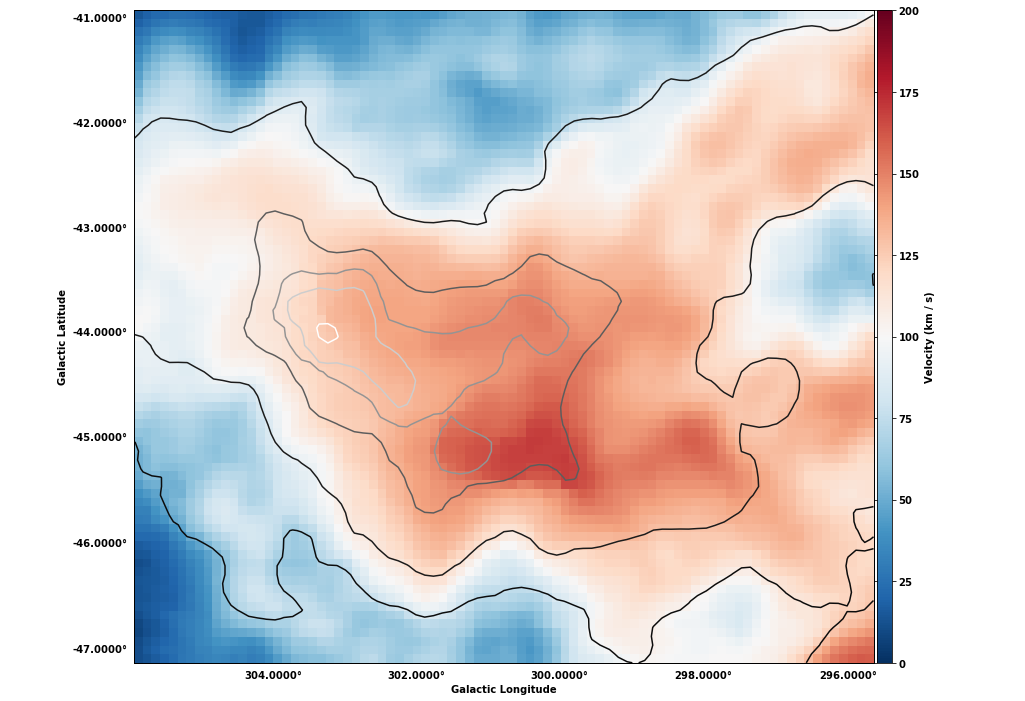

In [132]:
# Initiate a figure 
fig = plt.figure(figsize = (18,12))

# Initiate a FITSFigure to set up axes
F = aplpy.FITSFigure(moment_1.hdu, figure = fig)

# display a colorscale map of moment_1
F.show_colorscale(cmap = 'RdBu_r', vmin = 0., vmax = 200.)
# display a colorbar
F.show_colorbar(axis_label_text = 'Velocity (km / s)')

# overplot contours of hi_column_density (essentially column density here)
F.show_contour(hi_column_density.hdu, cmap = 'Greys_r', levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22))

# Find and Download a Herschel Image

This is great, but we want to compare the HI emission data with Herschel 350 micron emission to trace some dust. This can be done easily with [astroquery](http://www.astropy.org/astroquery/). 
We can query for the data by mission, take a quick look at the table of results, and download data after selecting a specific wavelength or filter. 

Since we are looking for Herschel data from an ESA mission, we will use the [astroquery.ESASky](http://astroquery.readthedocs.io/en/latest/esasky/esasky.html) class.

Specifically, the ESASKY.query_region_maps() method allows us to search for a specific region of the sky either using an astropy SkyCoord object or a string specifying an object name. In this case, we can just search for the SMC. A radius to search around the object can also be specified.

In [133]:
from astroquery.esasky import ESASky # Import the ESASky Class

In [136]:
# Query for Herschel data in a 1 degree radius around the SMC
result = ESASky.query_region_maps('SMC', radius = 1*u.deg, missions = 'Herschel')

print(result)

TableList with 1 tables:
	'0:HERSCHEL' with 11 column(s) and 24 row(s) 


Here, result is a TableList which contains 24 Herschel data products that can be downloaded. We can print some details about these objects using .show_in_notebook()

In [138]:
result['HERSCHEL'].show_in_notebook()

## Using reproject to match different resolution data

Using again [APLpy FITSFigure](http://aplpy.readthedocs.io/en/stable/api/aplpy.FITSFigure.html) will make a map of the zeroth moment for the HI with the Herschel data show as contours of the intesnity. Both data sets have different resolutions, with Hershcel having the higher resolution one.

We initialze a figure in matplotlib and plot the intesity map of HI using APLpy FITSFigure.  FITSFigure requires an HDU object as its argument to determine coordinates, axis labes and scales. 'show_colorscale' and 'show_colorbar' modifies the color attribute of the plot and the properties of the color bar.

'show_contour' plots countours of a data file for our case the Herschel data.  The data file has to be an HDU object, for this case the 'herschel_imagehdu'.  

In this case the resolution of the contours exceeds that of the HI data.  If one want to have the highest resolution data match that of the poor resolution one (or vice versa) , we can use [reproject](https://reproject.readthedocs.io/en/stable/)

In [ ]:
fig = plt.figure(figsize = (18,12)) #Generates the figure, fig, using matplotlib with a size of 18'x12'

F = aplpy.FITSFigure(sub_cube_m0.hdu, figure = fig) #Plots the zeroth moment of HI (sub_cube_m0 object) in figure 'fig'

F.show_colorscale(cmap = 'YlGnBu_r', aspect = 'auto', stretch = 'log') #Selects the color map, aspect and colorscale for the figure
F.show_colorbar(axis_label_text = 'Temperature * Velocity (K km / s)') #It generates a color bar with the apropiate label
F.show_contour(herschel_imagehdu, cmap = 'Reds', alpha = .5, levels=3) #It generates the contours for the herschel image hdu object

[reproject](https://reproject.readthedocs.io/en/stable/) is a libary that can match two data sets with different resolution to have the same one.  When the low resolution data is modify to a high resolution it uses and interpolation mechanism. The imput it takes are HDU objects.

The first command generates the image array of the herschel data given by 'herschel_imagehdu' with the resolution of the HI data determined by 'sub_cube_m0.header'.  [reproject](https://reproject.readthedocs.io/en/stable/) uses the WCS to tranform the coordinates that is in the header part of the HDU objects.

In order to plot using [APLpy FITSFigure](http://aplpy.readthedocs.io/en/stable/api/aplpy.FITSFigure.html) we need to transform the image array to an HDU object, we do that with the second command.

We plot the new data similarly to the previous plot but now the countours form herschel correspond to the newly form data that has the same resoltuion of the HI data.

In [ ]:
from reproject import reproject_interp #Imports the library reproject

rescaled_herschel_image, ___ = reproject_interp(herschel_imagehdu,
                                                sub_cube_m0.header) # Obtains the rescaled herschel image
rescaled_herschel_image_hdu = fits.PrimaryHDU(data=rescaled_herschel_image,
                                              header=sub_cube_m0.header) # Generates an HDU object for the image

fig = plt.figure(figsize = (18,12))

F = aplpy.FITSFigure(sub_cube_m0.hdu, figure = fig)

F.show_colorscale(cmap = 'YlGnBu_r', aspect = 'auto', stretch = 'log')
F.show_colorbar(axis_label_text = 'Temperature * Velocity (K km / s)')
F.show_contour(rescaled_herschel_image_hdu, cmap = 'Reds', alpha = .6, levels=10)

# Library imports

In [1]:
from astropy.utils.data import download_file
from astropy.io import fits
import os
from spectral_cube import SpectralCube
from astropy import units as u
import astropy.coordinates as coord
from astroquery.esasky import ESASky
import astroquery
import numpy as np
from astropy.wcs import WCS
import aplpy
import matplotlib.pyplot as plt
%matplotlib inline

# Reading/Downloading HI data

HI data is form the HI4PI survey. 

In [2]:
'''
It checks working directory for data file.  If data is not present it downlowds it.  Data file is save as hi_data. 
cube: is the HI data array.
'''

if not os.path.isfile('TAN_C14.fits'):
    hi_datafile = download_file('http://cdsarc.u-strasbg.fr/vizier/ftp/cats/J/A+A/594/A116/CUBES/GAL/TAN/TAN_C14.fits',
                       cache=True)
else:
    hi_datafile = 'TAN_C14.fits'

hi_data = fits.open(hi_datafile)
cube = SpectralCube.read(hi_data)
hi_data.close()


/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


In [3]:
'''
This prits the characteristics of the data cube. Dimension, coord system, units, value range.
'''
cube

SpectralCube with shape=(933, 277, 269) and unit=K:
 n_x:    269  type_x: GLON-TAN  unit_x: deg    range:   286.707162 deg:  320.913024 deg
 n_y:    277  type_y: GLAT-TAN  unit_y: deg    range:   -51.659734 deg:  -28.394756 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s

# Reading/Downloading Infrared data

Infrared data is from Herschel

In [4]:
'''
Todo: Change 'result' to 'map'.
Opens and using astroquery the Herschel map of the SMC
result: is a table witht he availabe data around the SMC with 1 degree with the Herschel data.
'''

result = ESASky.query_region_maps('SMC', radius = 1*u.deg, missions = 'Herschel')
print(result)

TableList with 1 tables:
	'0:HERSCHEL' with 11 column(s) and 24 row(s) 


In [5]:
'''
Within result, we have one table called HERSCHEL. This Table has 11 columns of which filter is one. We are looking
for a particular observation which was taken with the 350micron filter. This observation was made in a paper that 
includes observations in 250 and 500 micron filters as well. Hence to identify the observations that we are after, 
we search for the observation with filters '250, 350, 500'. 

In order for that data to be accepted by the get_maps function, we need to convert the specific result to a TableList
That is what is done in the last statement.

filters: generates a table from 'result' that it will be filter at the corresponding wavelenghts.

'''

filters = result['HERSCHEL']['filter'].astype(str)

ind = np.array(['250, 350, 500' == s for s in filters], dtype = 'bool')

target_obs = astroquery.utils.TableList({"HERSCHEL":result['HERSCHEL'][np.array(ind, dtype='bool')]})

In [6]:
'''
Here we download the data from the esac.esa.int website.

TODO: May be add if statement to check if the file exists.
'''

images = ESASky.get_maps(target_obs)

Starting download of HERSCHEL data. (1 files)
INFO: Maps available at /Volumes/DK_Storage/Data/Tilted_Ring_data/model_cubes/Elliptical/astropy_tutorial/astropy-tutorials/tutorials/FITS-cubes/Maps [astroquery.esasky.core]


In [7]:
'''
Here we select the 350micron filter from the downloaded data
'''

images['HERSCHEL'][0]['350'].info()

Filename: Maps/HERSCHEL/hspirepmw401_25pxmp_0110_m7303_1342198565_1342198566_1462476888800.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     184   ()      
  1  image         1 ImageHDU        47   (2407, 2141)   float64   
  2  error         1 ImageHDU        47   (2407, 2141)   float64   
  3  coverage      1 ImageHDU        47   (2407, 2141)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   84R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   65R x 4C   [1K, 27A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   450R x 10C   [1K, 20A, 13A, 196A, 1L, 1K, 1L, 74A, 11A, 41A]   


In [8]:
'''
Here we are grabing the WCS (World Coordinate System?) keywords from the header of the file, so that we can maniplulate
the coordinates of the pixels later.

Also here we are taking in the herschel image.

'''

w = WCS(images['HERSCHEL'][0]['350'][0])
herschel_imagehdu = images['HERSCHEL'][0]['350'][1]
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 18.99666058287459  -71.828763749063185  
CRPIX : 1769.0  2527.0  
NAXIS : 0  0


INFO: Auto-setting vmin to -1.813e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.659e+01 [aplpy.core]


/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


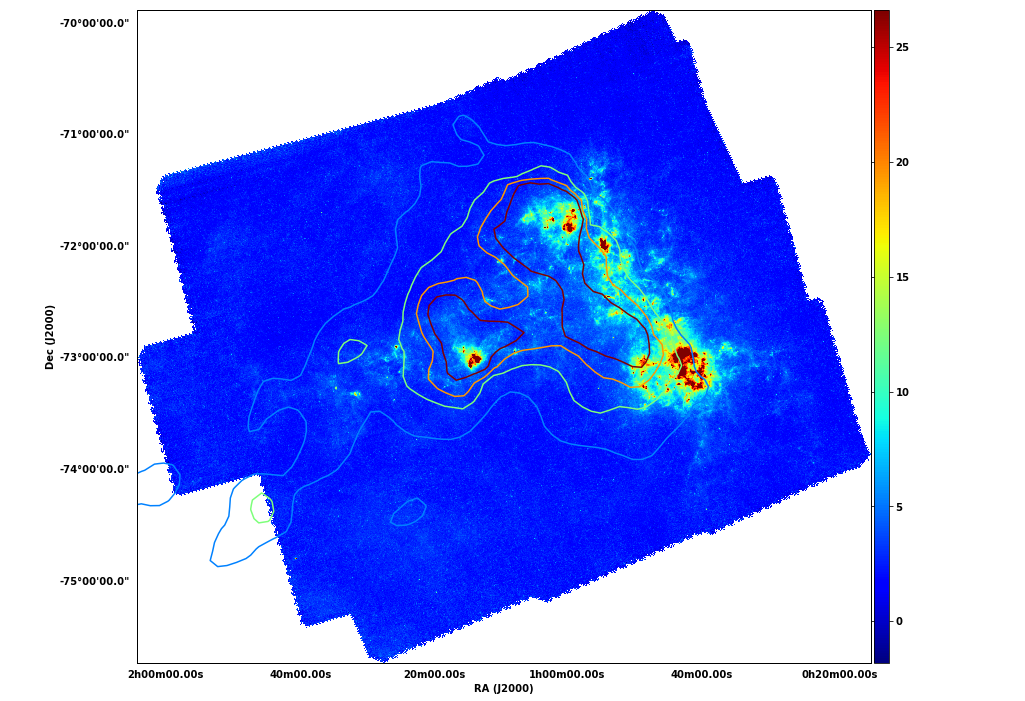

In [9]:
'''
The first statement here is setting up the plotting figure as a 18x12 inches
plot. 

Next we use the APLpy.FITSFigure function to plot the herschel_imagehdu onto 
the figure 'fig'. We then use the F.show_colorscale to show the plot using
the default colorscale. The value of the colors is presented in the 
colorbar on the plot. 

In order to overplot the HI information from the previously downloaded 
datacube we use F.use_contour function. Here we only plot the velocity 
field at index 600. (TODO) The value of the contours of the plot are presented
on the contour lines themselves using the last statement.

'''

fig = plt.figure(figsize = (18,12))

F = aplpy.FITSFigure(herschel_imagehdu, figure = fig)

F.show_colorscale()
F.show_colorbar()
F.show_contour(cube.hdu, slices = [600])


In [10]:
def find_nannearest_idx(array,value):
    idx = np.nanargmin(np.abs(array-value))
    return idx

lat_range = [-46, -40]
lon_range = [306, 295]

# Find lattitude index values
_, b, _ = cube.world[0,:,0] #extract latitude world coordinates from cube
_, _, l = cube.world[0,0,:] #extract longitude world coordinates from cube
b = b.value
l = l.value
lat_range_idx = sorted([find_nannearest_idx(b, lat_range[0]), find_nannearest_idx(b, lat_range[1])])
lon_range_idx = sorted([find_nannearest_idx(l, lon_range[0]), find_nannearest_idx(l, lon_range[1])])


# Create a sub_cube cut to these coordinates and convert to km/s
sub_cube = cube[:,lat_range_idx[0]:lat_range_idx[1], lon_range_idx[0]:lon_range_idx[1]].with_spectral_unit(u.km / u.s)

sub_cube_m0 = sub_cube.moment(order = 0)

/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


INFO: Auto-setting vmin to  1.529e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.920e+03 [aplpy.core]


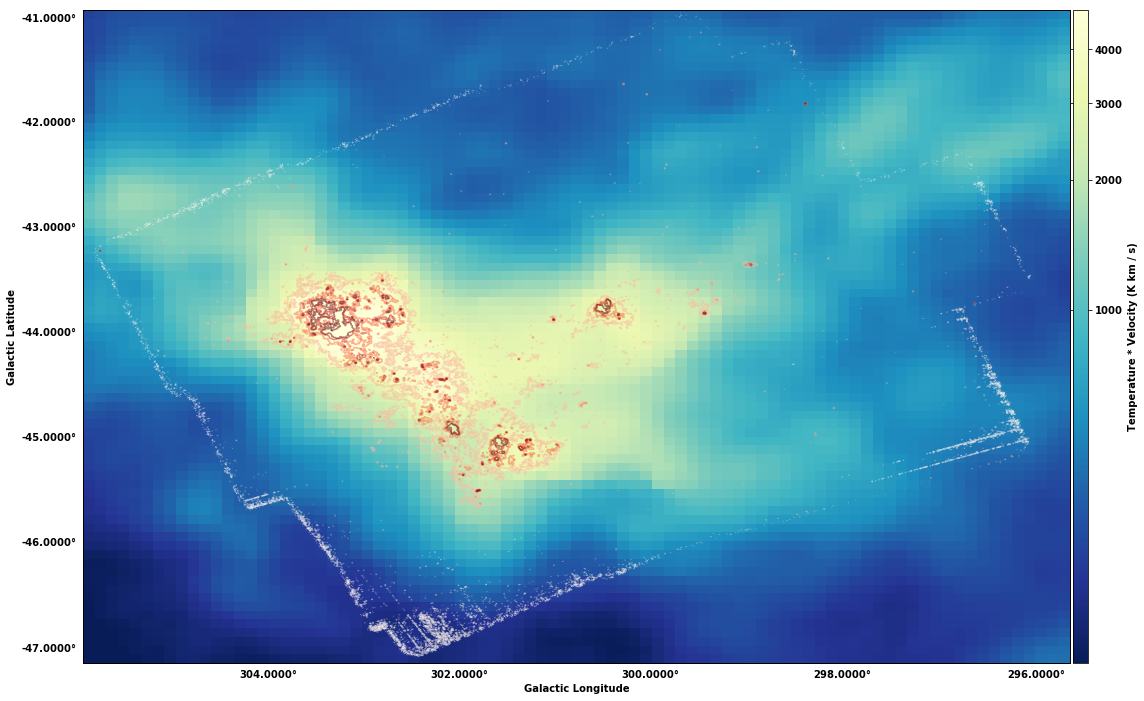

In [11]:
fig = plt.figure(figsize = (18,12))

F = aplpy.FITSFigure(sub_cube_m0.hdu, figure = fig)

F.show_colorscale(cmap = 'YlGnBu_r', aspect = 'auto', stretch = 'log')
F.show_colorbar(axis_label_text = 'Temperature * Velocity (K km / s)')
F.show_contour(herschel_imagehdu, cmap = 'Reds', alpha = .5)

INFO: Auto-setting vmin to  1.529e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.920e+03 [aplpy.core]


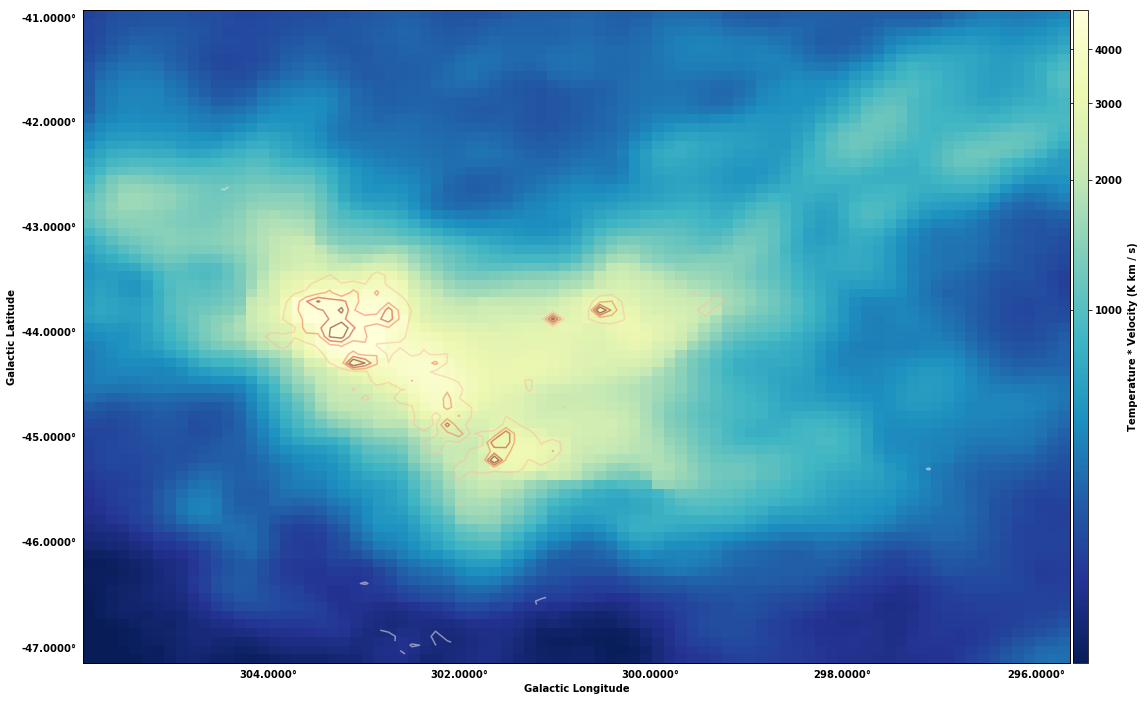

In [60]:
from reproject import reproject_interp

'''
The first statement reprojects the herschel_imagehdu to the scale and
resolution of sub_cube_m0. Then we write the new 
image to a new fits file, along with the header from sub_cube_m0 (which
contains the WCS info), so that we can cleanly
pass it onto the show_contour function 

'''

rescaled_herschel_image, ___ = reproject_interp(herschel_imagehdu,
    sub_cube_m0.header)
rescaled_herschel_image_hdu = fits.PrimaryHDU(data=rescaled_herschel_image, header=sub_cube_m0.header)

fig = plt.figure(figsize = (18,12))

F = aplpy.FITSFigure(sub_cube_m0.hdu, figure = fig)

F.show_colorscale(cmap = 'YlGnBu_r', aspect = 'auto', stretch = 'log')
F.show_colorbar(axis_label_text = 'Temperature * Velocity (K km / s)')
F.show_contour(rescaled_herschel_image_hdu, cmap = 'Reds', alpha = .5)

In [ ]:
result['HERSCHEL'][np.array(ind, dtype='bool')].show_in_notebook()

In [ ]:
images = ESASky.get_maps(astroquery.utils.TableList(result['HERSCHEL'][np.array(ind, dtype='bool')]), 
                         cache = False)

In [ ]:
type(images)

In [ ]:
table = result['HERSCHEL']
print(table)

In [ ]:
test = astroquery.utils.TableList(result['HERSCHEL'][np.array(ind, dtype='bool')])

In [ ]:
test['HERSCHEL'].show_in_notebook()

In [ ]:
test = astroquery.utils.TableList({"HERSCHEL":result['HERSCHEL'][np.array(ind, dtype='bool')]})